# Live Data Preparation

This Notebook focuses on the preparation of our collected live data and the creation of datasets that can be used to train our models.

In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from helper import *

In [2]:
t = "20Min" # resolution (eg. grouping the data on 60 min steps)
long_interpolation = 4 # we use a different interpolation method for longer periods of missing data

## Import dataframes

We created multiple CSV files while collecting the Data. In this case, we have created a separate CSV per day. These have to be read in separately and then combined to a single dataframe.

In [3]:
def load_csv(file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
    else:
        df = pd.DataFrame()
    return df

def combine_dataframes(path_comb, path_live, csv_comb="combined.csv"):
    
    df_combined = load_csv(path_comb + csv_comb)

    for file in os.listdir(path_live):
        if str(file).endswith(".csv"):
            df = pd.read_csv(f"{path_live}{file}", delimiter=",")
            df_combined = df_combined.append(df)
    return df_combined
        
file = "combined.csv"
path_comb = "../data/"
path_live = "../data/"
    
df = combine_dataframes(path_comb, path_live, csv_comb=file)

## Dataset preparation



### Drop duplicate values

Since the API does not update every minute, we sometimes collect duplicate values, which need to be filtered out now.

In [4]:
print(f"{round((1 -len(df.drop_duplicates()) / len(df)) * 100, 2)} % of entries are duplicates")

37.74 % of entries are duplicates


In [5]:
df = df.drop_duplicates()

### Update timestamp
Updating the timestamp format

In [6]:
df = update_timestamps(df)

### Drop irrelevant columns
We drop columns which are not releant for us. These are 
- link: link to the garage
- geo_point_2d: coordinates of the garage
- description: short sentence which combines information of the other columns.

In [7]:
df = df.drop(columns=["link", "geo_point_2d", "description"])

### Resample timestamp intervall

Below we resample the time interval of our measurement data. This summarises the car park utilisation with the average values in our new intervalls. 

In [8]:
df = resample_timestamp(df, t=t, how="mean", ignore_cols=['published', "description"])

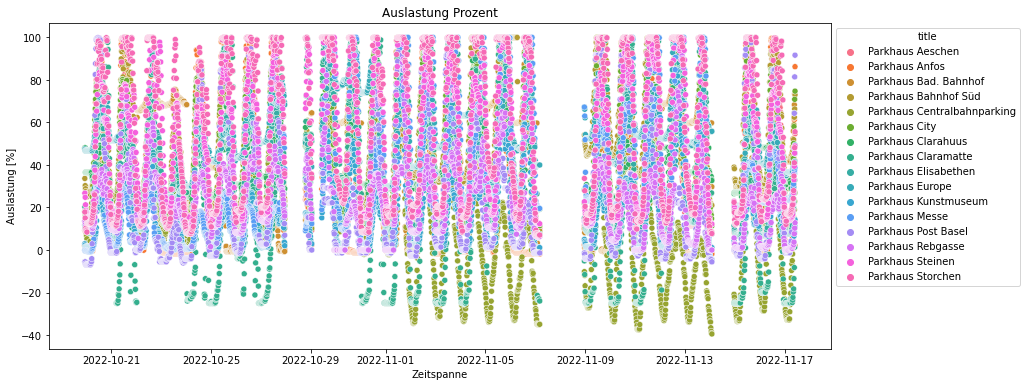

In [9]:
plt.figure(figsize=(14,6))

ax = sns.scatterplot(data = df.dropna(), x="published", y="auslastung_prozent", hue="title")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Auslastung Prozent")
plt.ylabel("Auslastung [%]")
plt.xlabel("Zeitspanne")
plt.show()

In [10]:
df = df.groupby(by=["id2", "name", "title"]).apply(mark_missing_values_windows)        
df = df.reset_index(drop=True)

In [11]:
df.loc[(df["missing"] == 0) & df.isna().any(axis=1)]

,name,id2,title,published,free,total,anteil_frei,auslastung,auslastung_prozent,missing


In [12]:
df.loc[df.isna().any(axis=1)]

,name,id2,title,published,free,total,anteil_frei,auslastung,auslastung_prozent,missing
578,Aeschen,aeschen,Parkhaus Aeschen,2022-10-27 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,59
579,Aeschen,aeschen,Parkhaus Aeschen,2022-10-27 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,59
580,Aeschen,aeschen,Parkhaus Aeschen,2022-10-28 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,59
581,Aeschen,aeschen,Parkhaus Aeschen,2022-10-28 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,59
582,Aeschen,aeschen,Parkhaus Aeschen,2022-10-28 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,59
...,...,...,...,...,...,...,...,...,...,...
32634,Storchen,storchen,Parkhaus Storchen,2022-11-14 21:40:00+00:00,NaN,NaN,NaN,NaN,NaN,63
32635,Storchen,storchen,Parkhaus Storchen,2022-11-14 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,63
32636,Storchen,storchen,Parkhaus Storchen,2022-11-14 22:20:00+00:00,NaN,NaN,NaN,NaN,NaN,63
32637,Storchen,storchen,Parkhaus Storchen,2022-11-14 22:40:00+00:00,NaN,NaN,NaN,NaN,NaN,63


In [13]:
df = interpolate_historic(df, 6)

C:\Users\samlu\Documents\GitHub\FHNW_chx_HS22\notebooks\helper.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c][i] = values[c]


In [14]:
df[df.isna().any(axis=1)]["missing"].value_counts()

3    48
2    32
Name: missing, dtype: int64

In [15]:
df

,name,id2,title,published,free,total,anteil_frei,auslastung,auslastung_prozent,missing
0,Aeschen,aeschen,Parkhaus Aeschen,2022-10-19 22:40:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0
1,Aeschen,aeschen,Parkhaus Aeschen,2022-10-19 23:00:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0
2,Aeschen,aeschen,Parkhaus Aeschen,2022-10-19 23:20:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0
3,Aeschen,aeschen,Parkhaus Aeschen,2022-10-19 23:40:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0
4,Aeschen,aeschen,Parkhaus Aeschen,2022-10-20 00:00:00+00:00,88.000000,97.0,0.907216,0.092784,9.278351,0
...,...,...,...,...,...,...,...,...,...,...
32811,Storchen,storchen,Parkhaus Storchen,2022-11-17 08:40:00+00:00,102.307692,142.0,0.720477,0.279523,27.952329,0
32812,Storchen,storchen,Parkhaus Storchen,2022-11-17 09:00:00+00:00,92.615385,142.0,0.652221,0.347779,34.777898,0
32813,Storchen,storchen,Parkhaus Storchen,2022-11-17 09:20:00+00:00,83.750000,142.0,0.589789,0.410211,41.021127,0
32814,Storchen,storchen,Parkhaus Storchen,2022-11-17 09:40:00+00:00,73.647059,142.0,0.518641,0.481359,48.135874,0


### Interpolate data

Since most time series models cannot handle missing values, these are interpolated in a next step. We distinguish between short missing values, which we interpolate linearly, and longer missing sections in the time series data, which we interpolate with the average values for this weekday and time.

In [16]:
n = len(df)

sub_df1 = df[:n]
sub_df1 = sub_df1.drop_duplicates()

ip = Interpolator()
sub_df2 = ip.interpolate(sub_df1, method="pad", t=t)

ip = Interpolator()
sub_df3 = ip.interpolate(sub_df1, method="linear", t=t)

ip = Interpolator()
sub_df4 = ip.interpolate(sub_df1, method="cubic", t=t)

In [17]:
sub_df2[sub_df2.isna().any(axis=1)]["missing"].value_counts()

Series([], Name: missing, dtype: int64)

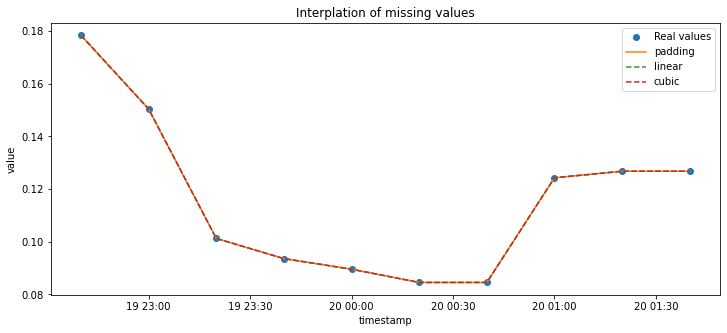

In [18]:
df1 = sub_df1.loc[sub_df1["title"] == "Parkhaus Storchen"][:10]
df2 = sub_df2.loc[sub_df2["title"] == "Parkhaus Storchen"][:10]
df3 = sub_df3.loc[sub_df3["title"] == "Parkhaus Storchen"][:10]
df4 = sub_df4.loc[sub_df4["title"] == "Parkhaus Storchen"][:10]

plt.figure(figsize=(12,5))
plt.plot(df1["published"], df1["auslastung"], "o", label="Real values")
plt.plot(df2["published"], df2["auslastung"], "-", label="padding")
plt.plot(df3["published"], df3["auslastung"], "--", label="linear")
plt.plot(df4["published"], df4["auslastung"], "--", label="cubic")
plt.title("Interplation of missing values")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend()
plt.show()

In [19]:
round(len(sub_df1) / len(sub_df2), 3)

1.0

In [20]:
df = sub_df2.drop(columns=["missing"])

In [21]:
df

,published,free,total,anteil_frei,auslastung,auslastung_prozent,title,name,id2
0,2022-10-19 22:40:00+00:00,910.666667,1114.0,0.817475,0.182525,18.252543,Parkhaus City,City,city
1,2022-10-19 23:00:00+00:00,917.214286,1114.0,0.823352,0.176648,17.664786,Parkhaus City,City,city
2,2022-10-19 23:20:00+00:00,931.000000,1114.0,0.835727,0.164273,16.427289,Parkhaus City,City,city
3,2022-10-19 23:40:00+00:00,950.857143,1114.0,0.853552,0.146448,14.644781,Parkhaus City,City,city
4,2022-10-20 00:00:00+00:00,963.571429,1114.0,0.864965,0.135035,13.503462,Parkhaus City,City,city
...,...,...,...,...,...,...,...,...,...
32811,2022-11-17 08:40:00+00:00,384.461538,526.0,0.730915,0.269085,26.908453,Parkhaus Steinen,Steinen,steinen
32812,2022-11-17 09:00:00+00:00,352.230769,526.0,0.669640,0.330360,33.035975,Parkhaus Steinen,Steinen,steinen
32813,2022-11-17 09:20:00+00:00,318.562500,526.0,0.605632,0.394368,39.436787,Parkhaus Steinen,Steinen,steinen
32814,2022-11-17 09:40:00+00:00,286.294118,526.0,0.544285,0.455715,45.571461,Parkhaus Steinen,Steinen,steinen


Unique garages

In [22]:
names = list(df["title"].drop_duplicates())
names

['Parkhaus City',
 'Parkhaus Anfos',
 'Parkhaus Bad. Bahnhof',
 'Parkhaus Kunstmuseum',
 'Parkhaus Post Basel',
 'Parkhaus Centralbahnparking',
 'Parkhaus Clarahuus',
 'Parkhaus Rebgasse',
 'Parkhaus Aeschen',
 'Parkhaus Europe',
 'Parkhaus Storchen',
 'Parkhaus Bahnhof Süd',
 'Parkhaus Messe',
 'Parkhaus Claramatte',
 'Parkhaus Elisabethen',
 'Parkhaus Steinen']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32816 entries, 0 to 32815
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published           32816 non-null  datetime64[ns, UTC]
 1   free                32816 non-null  float64            
 2   total               32816 non-null  float64            
 3   anteil_frei         32816 non-null  float64            
 4   auslastung          32816 non-null  float64            
 5   auslastung_prozent  32816 non-null  float64            
 6   title               32816 non-null  object             
 7   name                32816 non-null  object             
 8   id2                 32816 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(5), object(3)
memory usage: 2.3+ MB


### Check for missing values

In [24]:
df[df.isna().any(axis=1)]

,published,free,total,anteil_frei,auslastung,auslastung_prozent,title,name,id2


We see that there are no missing values left in the Dataset.

### Check for impossible utilisation rates

In [25]:
len(df.loc[df["auslastung_prozent"] > 100])

0

In [26]:
len(df.loc[df["auslastung_prozent"] < 0])

2421

There are no garages with a utilization rate above 100 percent. However, there are some garages that have negative proportional utilisation. This means that the garage has more parking spots than specified. Since we predict the free parking spots, this error in the utilisation rate is not further relevant for us.

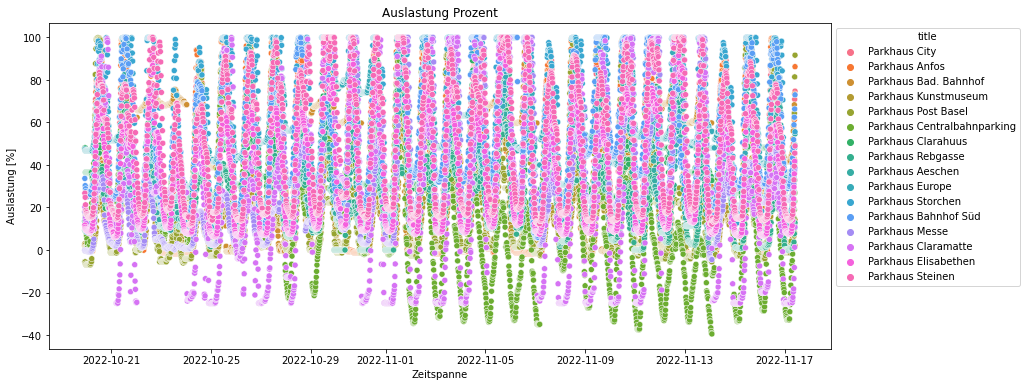

In [27]:
plt.figure(figsize=(14,6))
ax = sns.scatterplot(data = df, x="published", y="auslastung_prozent", hue="title")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Auslastung Prozent")
plt.ylabel("Auslastung [%]")
plt.xlabel("Zeitspanne")
plt.show()

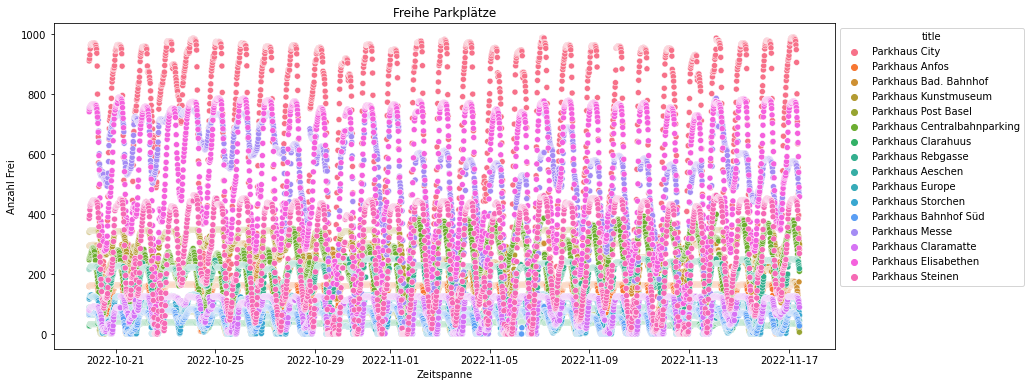

In [28]:
plt.figure(figsize=(14,6))
ax = sns.scatterplot(data = df, x="published", y="free", hue="title")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Freihe Parkplätze")
plt.ylabel("Anzahl Frei")
plt.xlabel("Zeitspanne")
plt.show()

### Save as csv

In [29]:
df.to_csv("../data/processed/live_20.csv", index=False)